#The plan will be 
1.Load, visualize and preprocess the data
2. Define Pytorch Dataset and Dataloader objects
3. Define an LSTM regression model
4.Train and evaluate the model

#Import necessary libraries

In [ ]:
!unzip household_power_consumption.zip

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: household_power_consumption.txt  


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
import pandas as pd
# Load the data into a Pandas DataFrame
power_data = pd.read_csv('household_power_consumption.txt', delimiter=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, na_values=['nan','?'])


In [ ]:
power_data.head()
power_data.dropna(inplace=True)

#Data Preprocessing

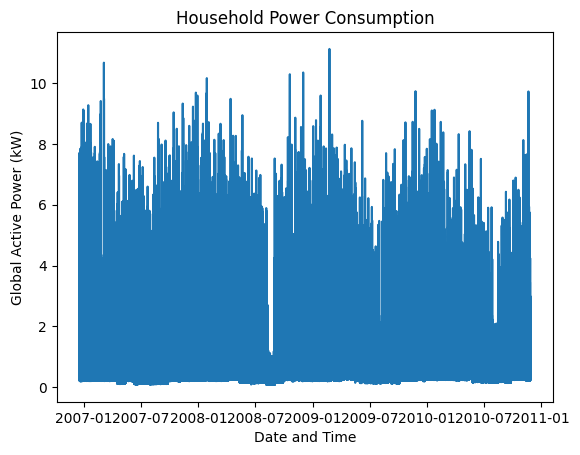

In [ ]:
# Create a line chart for the Global_active_power column
plt.plot(power_data['datetime'], power_data['Global_active_power'])
plt.xlabel('Date and Time')
plt.ylabel('Global Active Power (kW)')
plt.title('Household Power Consumption')
plt.show()


In [ ]:

X = power_data[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y= power_data['Global_active_power']

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the dataset
X = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
target_sensor = "Global_active_power"
features = ['Global_intensity', 'Global_reactive_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Voltage']
forecast_lead = 10
target = f"{target_sensor}"
print(features)
print(power_data[features].values)
print(target)

['Global_intensity', 'Global_reactive_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Voltage']
[[ 18.4     0.418   0.      1.     17.    234.84 ]
 [ 23.      0.436   0.      1.     16.    233.63 ]
 [ 23.      0.498   0.      2.     17.    233.29 ]
 ...
 [  3.8     0.      0.      0.      0.    239.82 ]
 [  3.8     0.      0.      0.      0.    239.7  ]
 [  3.8     0.      0.      0.      0.    239.55 ]]
Global_active_power


In [ ]:


# Convert X_train and Y_train to DataFrames
X_train_df = pd.DataFrame(X_train, columns=features)
y_train_df = pd.Series(y_train, name=target)
X_test_df = pd.DataFrame(X_test, columns=features)
y_test_df = pd.Series(y_test, name=target)


train_dataset= pd.concat([X_train_df, y_train_df], axis=1)
test_dataset=pd.concat([X_test_df, y_test_df], axis=1)

#Creating the sequence dataset
*Sequence length specifies the number of time steps.

features= a list of feature column names, target= target column name

.values() will give a numpy array corresponding to them

steps:
1. define init method containing necessary arguments
2. define len method giving the length of the Input
3. define get item method. here for the current data instance index it checks whether the current index is greater than the seq length given and then gives a time frame in which the slice of instances will be selected . Otherwise if the index position is lesser than the seq then add 0's too create the seq of gien length.
4. The method given above will return the seq of data before that index and the corresponding y value for the current index

In [ ]:
import torch
from torch.utils.data import Dataset


class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float().to(device)
        self.X = torch.tensor(dataframe[features].values).float().to(device)
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1 # set the start point
            x = self.X[i_start:(i + 1), :] # select the instances from the sliced time frame
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1) #padd the zeros 
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]


In [ ]:
train_dataset.shape
train_dataset


,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage,Global_active_power
0,-0.281351,0.675973,-0.771254,-0.182337,-0.051274,-0.765477,NaN
1,0.854186,-0.308599,0.668762,-0.182337,-0.051274,1.367944,5.360
2,1.705839,0.225353,0.353758,-0.182337,-0.223036,-0.765477,NaN
3,-0.174895,-0.219093,-0.816255,-0.182337,-0.051274,-0.765477,NaN
4,-1.097519,1.104987,0.218757,-0.182337,-0.223036,0.064187,3.666
...,...,...,...,...,...,...,...
1968476,NaN,NaN,NaN,NaN,NaN,NaN,0.392
2029253,NaN,NaN,NaN,NaN,NaN,NaN,1.156
1578356,NaN,NaN,NaN,NaN,NaN,NaN,1.172
1704226,NaN,NaN,NaN,NaN,NaN,NaN,0.258


In [ ]:
import pandas as pd


# Remove rows with NaN values
if train_dataset is None or test_dataset is None:
    print("Error: Failed to load CSV files!")
else:
    # Remove rows with NaN values
 train_dataset.fillna(train_dataset.mean(), inplace=True)
 test_dataset.fillna(test_dataset.mean(), inplace=True)

In [ ]:
train_dataset

,Global_intensity,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Voltage,Global_active_power
0,-0.281351,0.675973,-0.771254,-0.182337,-0.051274,-0.765477,1.091966
1,0.854186,-0.308599,0.668762,-0.182337,-0.051274,1.367944,5.360000
2,1.705839,0.225353,0.353758,-0.182337,-0.223036,-0.765477,1.091966
3,-0.174895,-0.219093,-0.816255,-0.182337,-0.051274,-0.765477,1.091966
4,-1.097519,1.104987,0.218757,-0.182337,-0.223036,0.064187,3.666000
...,...,...,...,...,...,...,...
1968476,0.000035,0.000210,0.000326,0.000111,-0.000829,0.000373,0.392000
2029253,0.000035,0.000210,0.000326,0.000111,-0.000829,0.000373,1.156000
1578356,0.000035,0.000210,0.000326,0.000111,-0.000829,0.000373,1.172000
1704226,0.000035,0.000210,0.000326,0.000111,-0.000829,0.000373,0.258000


In [ ]:
from torch.utils.data import DataLoader
torch.manual_seed(99)
sequence_length = 4
batch_size=32

train_seq_dataset = SequenceDataset(train_dataset, features=features,target= target,sequence_length=sequence_length)
test_seq_dataset = SequenceDataset(test_dataset,features=features, target=target, sequence_length=sequence_length)

#Creating the dataloaders
train_dataloader = DataLoader(train_seq_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_seq_dataset, batch_size=batch_size, shuffle=False)


#Model of LSTM
num_sensors= number of features in the input data

hidden_units = number of hidde units in LSTM layer
X is the input tensor of shape (batch_size, sequence_length, num_sensors)

num_layers= no of LSTM layers that we are going to use
steps:
1. define init method in ehich define the arguments and lstm and classification layer. the batch trues represent that the first dim of input will be the batch size.
2. define the forward function:
    a. initialize h0 with matrix of 0's of dim (n_layers, batch_size, n_hidden_units)
    b. intialize c0 with matrix of zeros of dim(n_layers, batch_size, n_hidden_units)
3. _, (hn, _) = self.lstm(x.to(device), (h0, c0)): passes the input tensor x and the initial hidden and cell states (h0, c0) to the LSTM. The first output _ is the sequence of hidden states for each timestep (which we don't use), and the second output (hn, _) is the final hidden and cell states. We ignore the second output (the final cell state) and keep only the final hidden state hn
4. out = self.linear(hn[0]).flatten(): passes the final hidden state hn[0] through a linear layer with weights self.linear to produce the output tensor out. We flatten out to remove any extraneous dimensions

In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(device)
        
        _, (hn, _) = self.lstm(x.to(device), (h0, c0))
        #print(hn.shape)

        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        #print(out.shape)
        #print(out)
        return out

In [ ]:
learning_rate = 5e-5
num_hidden_units = 16
model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=16)
model.to(device)

criterion= nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training the model

In [ ]:
train_loss_list = []
test_loss_list = []
test_acc_list = []
epochs = 5

for epoch in range(epochs):
    print(f"Epoch:{epoch}\n-------")

    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        #print(X.shape,y.shape)
        model.train()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        # train_acc += (y_pred.argmax(dim=1) == y).sum().item()

        if batch % 10000 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)
    train_loss_list.append(train_loss)
    print(f"Train loss: {train_loss:.4f} ")

    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += criterion(test_pred, y).item()

            # Compute accuracy
            # test_acc += (test_pred.argmax(dim=1) == y).sum().item()

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader.dataset)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"Test loss: {test_loss:.4f} ")


Epoch:0
-------
Looked at 0/1830864 samples.
Looked at 320000/1830864 samples.
Looked at 640000/1830864 samples.
Looked at 960000/1830864 samples.
Looked at 1280000/1830864 samples.
Looked at 1600000/1830864 samples.
Train loss: 0.8498 
Test loss: 0.6697 
Epoch:1
-------
Looked at 0/1830864 samples.
Looked at 320000/1830864 samples.
Looked at 640000/1830864 samples.
Looked at 960000/1830864 samples.
Looked at 1280000/1830864 samples.
Looked at 1600000/1830864 samples.
Train loss: 0.8374 
Test loss: 0.6695 
Epoch:2
-------
Looked at 0/1830864 samples.
Looked at 320000/1830864 samples.
Looked at 640000/1830864 samples.
Looked at 960000/1830864 samples.
Looked at 1280000/1830864 samples.
Looked at 1600000/1830864 samples.
Train loss: 0.8373 
Test loss: 0.6697 
Epoch:3
-------
Looked at 0/1830864 samples.
Looked at 320000/1830864 samples.
Looked at 640000/1830864 samples.
Looked at 960000/1830864 samples.
Looked at 1280000/1830864 samples.
Looked at 1600000/1830864 samples.
Train loss: 0.8